In [1]:
import os
from fig_gen  import FigureGenerator as fg
from sklearn.metrics import r2_score
import pwlf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
import seaborn as sns
import sklearn
from sklearn.linear_model import LinearRegression
%matplotlib inline
import missingno as msno
np.random.seed(19)
from matplotlib.pyplot import figure
data_directory = '/work2/05067/nagyz/austin_energy/data/'
filepaths = [os.path.join(data_directory,f) for f in os.listdir(data_directory) if f.endswith('.csv')]
from datetime import datetime 
from Graphs import load_data,load_graph_kwh,yearly_graph_kwh,load_graph_count,monthly_graph_kwh,daily_graph_kwh
from Graphs import load_graph_kwh_and_count,yearly_graph_kwh_and_count,monthly_graph_kwh_and_count,daily_graph_kwh_and_count
from agg_and_heatmap_functions import length,prav3,prav2,prav1,dinostorm,plot_aggraph,heatmap,finalheatmap
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, SGDRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.utils import resample
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Ridge,Lasso
from sklearn.model_selection import GridSearchCV,KFold
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
weather_daily=pd.read_csv('Austin_weather_daily.csv')
weather_daily['time']=pd.to_datetime(weather_daily['time'],utc=True)
weather_daily1=weather_daily.set_index('time',drop=True)
weather_austin_daily=weather_daily1['tavg']
cool_points=weather_austin_daily[weather_austin_daily<15]['2017-01-01 00:00:00+00:00':'2021-01-31 00:00:00+00:00']
# NOT UTC TIME
weather_Pred=pd.read_csv('Austin_hourly.csv')
weather_Pred['time']=pd.to_datetime(weather_Pred['time'])
weather_pred1=weather_Pred.set_index('time',drop=True)
weather_austin_hourl_pred=weather_pred1['temp']
import geopandas as gpd
from sklearn.preprocessing import MinMaxScaler

In [2]:
id_list = pd.read_csv('temporal_percentage1.csv')

id_list.drop('Unnamed: 0',axis=1,inplace=True)
id_list['buildingType'].unique()
res_type = ['SINGLE FAMILY', 'MULTIFAMILY',  'FOURPLEX', 
            'DUPLEX', 'CONDOS', 'CONDO (STACKED)', 
            '1 FAM DWELLING, ACCESSORY DWELLING UNIT',
            'TOWNHOMES','MOHO SINGLE PP', 
            '1 FAM DWELLING, GARAGE APARTMENT', 'MOHO DOUBLE PP',
            'MOHO SINGLE REAL', 'MOHO DOUBLE REAL', 'TRIPLEX', 
            '1 FAM DWELLING, MOHO DOUBLE REAL',
           '1 FAM DWELLING, MOHO SINGLE REAL']
res_type_id_list = id_list[id_list['buildingType'].isin(res_type)].copy()
res_type_id_list[['Service Point','zipCode']].head()

,Service Point,zipCode
2,-1609,78759
3,-1608,78759
12,-1599,78759
13,-1598,78759
14,-1597,78759


In [3]:
def prepare_data(service_point):
    sample=load_data(service_point)
    sample=sample.set_index(sample[sample.columns[0]])
    sample=sample[sample.columns[1:2]]
    sample=sample.resample('D').sum()
    return sample
def make_features(dataframe,time_level):
    s=dataframe
    start_time=s.index[0]
    end_time=s.index[-1]
    example_ts=s
    example_ts['dayofyear_cos']=np.cos(example_ts.index.dayofyear*(2.*np.pi/365))
    example_ts['dayofyear_sim']=np.sin(example_ts.index.dayofyear*(2.*np.pi/365))
    example_ts['month_cos']=np.cos(example_ts.index.month*(2.*np.pi/12))
    example_ts['month_sin']=np.sin(example_ts.index.month*(2.*np.pi/12))
    example_ts['year'] = example_ts.index.year

    for ts in example_ts.index:
        if time_level=='hourly':
             example_ts.loc[ts:ts, 'TMP'] = weather_austin_hourl_pred[weather_austin_hourl_pred.index == ts] 
        else:
             example_ts.loc[ts:ts, 'TMP'] = weather_austin_hourl_pred[weather_austin_hourl_pred.index == ts]

    return example_ts

In [21]:
def function(servicepoint):  
    s=prepare_data(servicepoint)
    s = s.rename(columns={list(s.columns.values)[0]: 'Energy_kwh'})
    train_set=s[:'2021-02-10']
    test_set=s['2021-02-11':'2021-02-19']
    k=5
    residential_train_Data_servicepoint=make_features(train_set,'daily')
    residential_test_data_service_point=make_features(test_set,'daily')
    resi_winter_temp=residential_test_data_service_point['TMP']
    resi_below_5=residential_train_Data_servicepoint[residential_train_Data_servicepoint['TMP']<5]
    plt.scatter(resi_below_5['TMP'],resi_below_5['Energy_kwh'])
    plt.show()
    Q1=resi_below_5[resi_below_5.columns[0]].quantile(0.25)
    Q3=resi_below_5[resi_below_5.columns[0]].quantile(0.75)
    IQR=Q3-Q1
    th=Q1-1.5*IQR
    Index=resi_below_5[(resi_below_5['Energy_kwh'] <th ) & (resi_below_5['TMP'] < 5) ].index
    resi_below_5_1=resi_below_5.drop(Index)
    q=resi_below_5_1[resi_below_5_1['TMP']<5]
    plt.scatter(q['TMP'],q['Energy_kwh'])
    plt.xlabel('temperature(celsius)')
    plt.ylabel('kwh value')
    plt.title(f'{servicepoint}correlation for residential between temp and kwh value')
    m, b = np.polyfit(q['TMP'], q['Energy_kwh'], 1)
    plt.plot(q['TMP'], m*q['TMP'] + b,color='red')
    plt.show()
    print(q['TMP'].corr(q['Energy_kwh']))
    train_below_5=q[q.columns[k:]]
    test_below_5=q['Energy_kwh']
    lr_5=LinearRegression()
    lr_5.fit(train_below_5,test_below_5)
    resi_test_more_than_5=residential_train_Data_servicepoint[residential_train_Data_servicepoint['TMP']>5]
    train_above_5=resi_test_more_than_5[resi_test_more_than_5.columns[k:]]
    test_above_5=resi_test_more_than_5['Energy_kwh']
    lr_above_5=LinearRegression()
    lr_above_5.fit(train_above_5,test_above_5)
    winter_test_data=residential_test_data_service_point[residential_test_data_service_point.columns[k:]]
    winter_data_below_5=winter_test_data[winter_test_data['TMP']<5]
    winter_data_above_5=winter_test_data[winter_test_data['TMP']>5]
    pred_below_5=lr_5.predict(winter_data_below_5)
    a=pred_below_5
    frames=[a]
    predictions = np.concatenate(frames)
    perc_diff=100*(pred_below_5-residential_test_data_service_point['Energy_kwh']['2021-02-11':'2021-02-19'])/residential_test_data_service_point['Energy_kwh']['2021-02-11':'2021-02-19']
    di=pd.DataFrame(perc_diff)
    di['timestamp']=di.index
    figure(figsize=(15,10), dpi=80)
    fig, ax1 = plt.subplots(figsize=(15,5))
    ax1.bar(di['timestamp'],di['Energy_kwh'],color='blue')
    ax1.legend(['kwh difference between measured load and predicted load'],loc='center')
    ax2=ax1.twinx()
    ax2.plot(residential_test_data_service_point['TMP']['2021-02-11':'2021-02-19'],color='red')
    ax2.legend(['temp celcius'])
    plt.title(servicepoint)
    plt.show()
    return resi_below_5_1,perc_diff

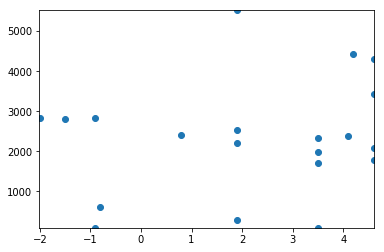

169.69322204589844


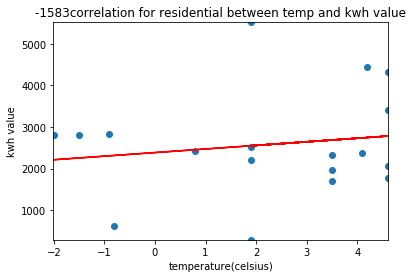

0.1546244623021897


<Figure size 1200x800 with 0 Axes>

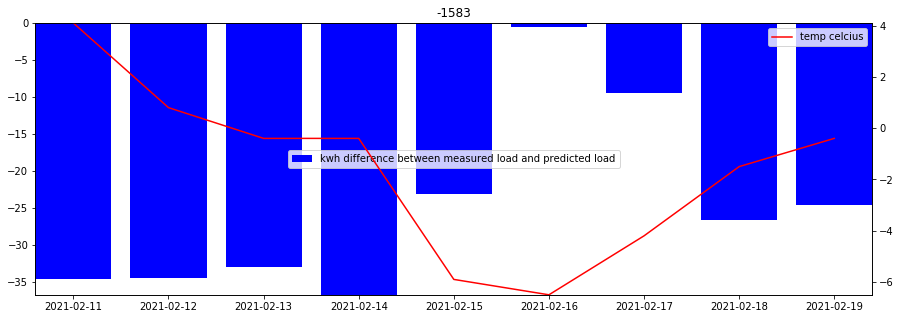

In [23]:
a,b=function(-1583)

In [24]:
a

,Energy_kwh,dayofyear_cos,dayofyear_sim,month_cos,month_sin,year,TMP
-1583 kWh DateTime,,,,,,,
2017-12-08,283.013201,0.922640,-0.385663,1.000000e+00,-2.449294e-16,2017,1.9
2017-12-28,2378.998793,0.998667,-0.051620,1.000000e+00,-2.449294e-16,2017,4.1
2018-01-01,606.854994,0.999852,0.017213,8.660254e-01,5.000000e-01,2018,-0.8
2018-01-02,2821.361004,0.999407,0.034422,8.660254e-01,5.000000e-01,2018,-0.9
2018-01-03,2805.444988,0.998667,0.051620,8.660254e-01,5.000000e-01,2018,-1.5
2018-01-17,2818.776014,0.957485,0.288482,8.660254e-01,5.000000e-01,2018,-2.0
2018-01-18,2413.766602,0.952378,0.304921,8.660254e-01,5.000000e-01,2018,0.8
2018-02-13,2071.856593,0.726608,0.687053,5.000000e-01,8.660254e-01,2018,4.6
2019-01-03,2320.433002,0.998667,0.051620,8.660254e-01,5.000000e-01,2019,3.5


In [7]:
def function1():
    date_columns=col=['2021-02-11', '2021-02-12', '2021-02-13', '2021-02-14',
               '2021-02-15', '2021-02-16', '2021-02-17', '2021-02-18',
               '2021-02-19']
    a=pd.DataFrame(index=res_type_id_list['Service Point'],columns=date_columns)
    for i in tqdm(res_type_id_list['Service Point']):
        s=prepare_data(i)
        s = s.rename(columns={list(s.columns.values)[0]: 'Energy_kwh'})
        train_set=s[:'2021-02-10']
        test_set=s['2021-02-11':'2021-02-19']
        k=5
        residential_train_Data_servicepoint=make_features(train_set,'daily')
        residential_test_data_service_point=make_features(test_set,'daily')
        resi_winter_temp=residential_test_data_service_point['TMP']
        resi_below_5=residential_train_Data_servicepoint[residential_train_Data_servicepoint['TMP']<5]
        Q1=resi_below_5[resi_below_5.columns[0]].quantile(0.25)
        Q3=resi_below_5[resi_below_5.columns[0]].quantile(0.75)
        IQR=Q3-Q1
        th=Q1-1.5*IQR
        for index,row in resi_below_5[resi_below_5['TMP']<5].iterrows():
            if row['Energy_kwh']<th and row['TMP']<0:
                resi_below_5_1=resi_below_5.drop(index)
            else:
                resi_below_5_1=resi_below_5
        q=resi_below_5_1[resi_below_5_1['TMP']<5]
        m, b = np.polyfit(q['TMP'], q['Energy_kwh'], 1)
        train_below_5=q[q.columns[k:]]
        test_below_5=q['Energy_kwh']
        lr_5=LinearRegression()
        lr_5.fit(train_below_5,test_below_5)
        resi_test_more_than_5=residential_train_Data_servicepoint[residential_train_Data_servicepoint['TMP']>5]
        train_above_5=resi_test_more_than_5[resi_test_more_than_5.columns[k:]]
        test_above_5=resi_test_more_than_5['Energy_kwh']
        lr_above_5=LinearRegression()
        lr_above_5.fit(train_above_5,test_above_5)
        winter_test_data=residential_test_data_service_point[residential_test_data_service_point.columns[k:]]
        winter_data_below_5=winter_test_data[winter_test_data['TMP']<5]
        winter_data_above_5=winter_test_data[winter_test_data['TMP']>5]
        pred_below_5=lr_5.predict(winter_data_below_5)
        a1=pred_below_5
        frames=[a1]
        predictions = np.concatenate(frames)
        perc_diff=100*(pred_below_5-residential_test_data_service_point['Energy_kwh']['2021-02-11':'2021-02-19'])/residential_test_data_service_point['Energy_kwh']['2021-02-11':'2021-02-19']
        a.loc[i]=perc_diff
    return a

In [8]:
#final_df=function1()

In [9]:
#final_df.to_csv('final_df1_new',index=True)

In [6]:
final_df1_new=pd.read_csv('final_df1_new')
final_df1_new
# service

,Service Point,2021-02-11,2021-02-12,2021-02-13,2021-02-14,2021-02-15,2021-02-16,2021-02-17,2021-02-18,2021-02-19
0,-1609,8.649804,13.551565,-5.738176,-12.066845,-19.179172,10.826855,12.908038,-1.937156,-9.363900
1,-1608,-13.811927,5.717055,-23.845450,-30.916630,3.672749,71.896492,114.617535,0.299620,-14.553241
2,-1599,8.755086,-8.998191,-22.730254,-25.275234,2.607866,47.281210,21.365857,7.888954,-3.743036
3,-1598,-14.862587,-11.481666,-29.218129,-33.654033,-15.271677,45.760116,31.750326,-16.971418,-25.313160
4,-1597,-15.777517,-13.263326,-24.852458,-28.147401,5.200229,61.202020,57.677072,-15.721169,-12.309440
...,...,...,...,...,...,...,...,...,...,...
369,-1004,-28.008988,-27.674924,-27.345866,-29.160030,15.481276,89.038677,52.762507,-16.718067,-10.593242
370,-1003,-22.135584,-26.507967,-25.326080,-28.689466,11.413601,58.807652,48.854538,-9.913129,-8.030815
371,-1002,-23.492667,-24.002346,-24.961171,-29.502702,-30.561716,-25.811621,-19.339838,-26.613460,-21.189991
372,-1001,-23.856769,-23.272096,-23.070991,-25.924429,26.463386,95.771480,33.968366,-28.057013,-22.129782


In [7]:
final_df1_new.head()

,Service Point,2021-02-11,2021-02-12,2021-02-13,2021-02-14,2021-02-15,2021-02-16,2021-02-17,2021-02-18,2021-02-19
0,-1609,8.649804,13.551565,-5.738176,-12.066845,-19.179172,10.826855,12.908038,-1.937156,-9.363900
1,-1608,-13.811927,5.717055,-23.845450,-30.916630,3.672749,71.896492,114.617535,0.299620,-14.553241
2,-1599,8.755086,-8.998191,-22.730254,-25.275234,2.607866,47.281210,21.365857,7.888954,-3.743036
3,-1598,-14.862587,-11.481666,-29.218129,-33.654033,-15.271677,45.760116,31.750326,-16.971418,-25.313160
4,-1597,-15.777517,-13.263326,-24.852458,-28.147401,5.200229,61.202020,57.677072,-15.721169,-12.309440


In [8]:
#crazy values
final_df1_new[np.isinf(final_df1_new).any(1)]


,Service Point,2021-02-11,2021-02-12,2021-02-13,2021-02-14,2021-02-15,2021-02-16,2021-02-17,2021-02-18,2021-02-19
118,-1406,-18.192582,-18.059434,-21.174633,-22.314959,42.515394,inf,inf,74.779406,-6.859287
119,-1405,-24.224788,-25.328763,-26.576655,-29.373759,52.560584,inf,inf,170.113589,-15.339074
121,-1403,-25.891431,-28.220808,-29.312018,-32.452803,40.946880,inf,inf,133.496465,-17.183876
175,-1309,-28.709356,-32.031957,-33.824957,-37.085132,-40.405363,inf,-1.855076e+01,-25.156770,-27.107940
192,-1291,-25.075733,-29.559438,-30.009184,-35.341934,70.388891,inf,4.139275e+04,10.313851,-44.496672
252,-1212,-13.034326,-22.448189,-24.797301,-25.321567,-36.102516,54.465833,inf,198.660821,-7.670210
373,-1000,-29.743510,-32.088085,-29.552013,-20.685401,53.332677,inf,inf,144.958779,-17.510063


In [9]:
final_df1_new_1=final_df1_new.set_index('Service Point',drop=True)

In [33]:
final_df1_new[final_df1_new['2021-02-14']>abs(100)]

,Service Point,2021-02-11,2021-02-12,2021-02-13,2021-02-14,2021-02-15,2021-02-16,2021-02-17,2021-02-18,2021-02-19
15,-1581,-1.975541e+09,3.019245e+10,4.001698e+10,3.774294e+10,1.305470e+11,2.345271e+11,1.682235e+11,6.573049e+10,4.792882e+10


In [15]:
final_df_outage=final_df1_new_1.loc[final_df1_new_1[final_df1_new_1 > abs(100)].any(axis=1)]
final_df_outage.replace([np.inf, -np.inf], np.nan, inplace=True)
# Drop rows with NaN
final_df_outage.dropna(inplace=True)
final_df_outage1=final_df_outage.reset_index()

final_df_outage1

,Service Point,2021-02-11,2021-02-12,2021-02-13,2021-02-14,2021-02-15,2021-02-16,2021-02-17,2021-02-18,2021-02-19
0,-1608,-13.811927,5.717055,-23.845450,-30.916630,3.672749,71.896492,114.617535,0.299620,-14.553241
1,-1594,-6.618686,-10.042476,-24.146235,-27.523140,-14.512844,173.468999,13.154875,-11.981479,-18.296768
2,-1593,-11.375529,-25.790331,-34.645925,-39.799662,-45.834304,179.667424,-41.056396,-31.348576,-31.023037
3,-1592,-19.488701,329.028123,-10.920657,-15.286097,-11.814283,-8.383692,9.765516,0.102861,-1.165173
4,-1590,-20.811204,26.441225,-26.209109,-31.755803,32.975866,219.951994,270.474451,4.494337,-27.014405
...,...,...,...,...,...,...,...,...,...,...
85,-1043,-18.989915,-28.167827,-30.376505,-33.975928,24.075796,235.948458,173.341154,1.174296,-26.421307
86,-1017,-5.325299,-11.878966,-15.136275,-14.116045,29.471035,295.753793,144.040963,-14.678753,-19.975755
87,-1012,-24.801951,-23.674011,-25.406773,-30.722277,69.712730,637.148339,61.979775,-30.687333,-17.817602
88,-1011,-10.779836,-19.055921,-22.855997,-28.966914,-31.453453,41.909028,532.712105,21.295222,-9.213920


In [16]:
dr=final_df1_new.set_index('Service Point',drop=True)
dr1=dr[dr<abs(100)].dropna()

dr1

,2021-02-11,2021-02-12,2021-02-13,2021-02-14,2021-02-15,2021-02-16,2021-02-17,2021-02-18,2021-02-19
Service Point,,,,,,,,,
-1609,8.649804,13.551565,-5.738176,-12.066845,-19.179172,10.826855,12.908038,-1.937156,-9.363900
-1599,8.755086,-8.998191,-22.730254,-25.275234,2.607866,47.281210,21.365857,7.888954,-3.743036
-1598,-14.862587,-11.481666,-29.218129,-33.654033,-15.271677,45.760116,31.750326,-16.971418,-25.313160
-1597,-15.777517,-13.263326,-24.852458,-28.147401,5.200229,61.202020,57.677072,-15.721169,-12.309440
-1595,-25.202928,-24.177647,-21.199972,-27.905429,-28.582631,-22.843525,-9.993516,-14.929988,-16.260689
...,...,...,...,...,...,...,...,...,...
-1005,-24.459615,-27.448179,-28.210916,-32.455311,-17.557978,-2.168407,-2.116127,-25.005095,-21.485048
-1004,-28.008988,-27.674924,-27.345866,-29.160030,15.481276,89.038677,52.762507,-16.718067,-10.593242
-1003,-22.135584,-26.507967,-25.326080,-28.689466,11.413601,58.807652,48.854538,-9.913129,-8.030815


In [17]:
dr1[np.isinf(dr1).any(1)]


,2021-02-11,2021-02-12,2021-02-13,2021-02-14,2021-02-15,2021-02-16,2021-02-17,2021-02-18,2021-02-19
Service Point,,,,,,,,,


In [18]:
#final_df1_new.replace([np.inf, -np.inf],0, inplace=True)
# Drop rows with NaN
shapefile = gpd.read_file('tl_2019_us_zcta510.shp')
shapefile.head()
shapefile['boundary']=shapefile.boundary
shapefile["area"] = shapefile.area
shapefile['centroid'] = shapefile.centroid
first_point = shapefile['centroid'].iloc[0]
shapefile['distance'] = shapefile['centroid'].distance(first_point)
shapefile['coords'] = shapefile['geometry'].apply(lambda x: x.representative_point().coords[:][0])

In [19]:
f1=dr1.merge(res_type_id_list[['Service Point','zipCode']],how='inner',on='Service Point').drop('Service Point',axis=1)
f2=f1.groupby(by='zipCode').median().reset_index()
#f2=f2.drop(labels=44,axis=0)
def plot_map(dataframe,date):
    i=date
    f3=dataframe[['zipCode',i]]
    """if f3[i].min()>0:
        scaler=MinMaxScaler(feature_range=(0,1))
    else:
        scaler=MinMaxScaler(feature_range=(-1,1))
    scaler.fit(np.array(f3[i]).reshape(-1,1))
    f5=scaler.transform(np.array(f3[i]).reshape(-1,1))
    f3['normalized_value']=f5"""
    f6=f3
    #f6=f3[['zipCode','normalized_value']]
    f6['zipCode']=f6['zipCode'].astype('int')
    shapefile['ZCTA5CE10']=shapefile['ZCTA5CE10'].astype(int)
    f6['zipCode']=f6['zipCode'].astype(int)
    gdf=shapefile.merge(f6,left_on='ZCTA5CE10',right_on='zipCode')
    fig, ax = plt.subplots(1,1, figsize=(15,10))
    ax.set_title(i)
    a,ax=fg.choropleth_plot(
        gdf,
        i,
        ax=ax,
        vmin=-100,
        vmax=100,
        edgecolor='black',
        legend=True,
        legend_kwds={'label':'% difference in predicted load and measured load','orientation':'vertical',},
    )
    for i, row in gdf.iterrows():
        ax.annotate(
            s=row['zipCode'],
            xy=row['coords'],
            ha='center',
            va='center',
            color='black',
            fontsize=10.5
        )
    plt.show()
f2.head()

,zipCode,2021-02-11,2021-02-12,2021-02-13,2021-02-14,2021-02-15,2021-02-16,2021-02-17,2021-02-18,2021-02-19
0,78617,-23.674718,-26.199403,-26.335973,-29.331366,-2.528977,28.319622,21.354817,-22.227908,-20.136975
1,78652,-25.495314,-28.391235,-34.137067,-39.176103,-44.681711,-36.224850,-29.159160,-29.872356,-26.365591
2,78660,-19.676180,-23.999900,-25.273074,-30.752590,24.206626,10.836623,3.225583,-12.518545,-15.566316
3,78701,-18.609965,-24.348758,-27.959664,-35.061631,-33.888956,-29.284115,-22.550586,-29.073531,-30.486693
4,78702,-13.498084,-25.272785,-27.766418,-33.278683,-19.767013,24.855945,42.343984,-24.424665,-30.250667


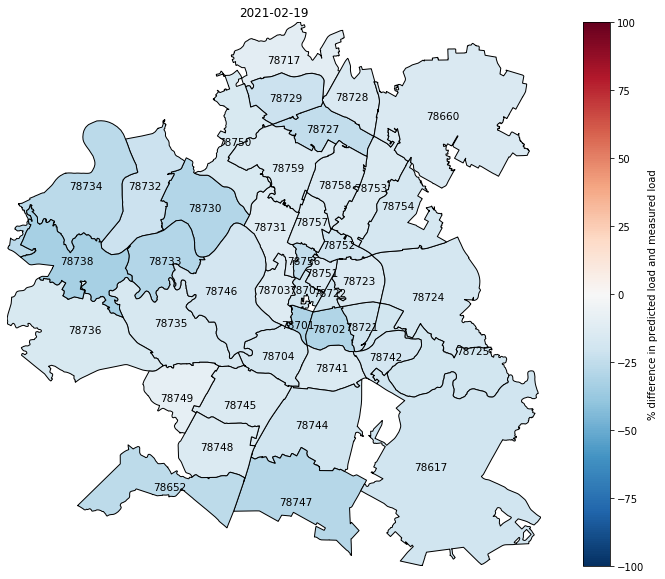

In [32]:
plot_map(f2,'2021-02-19')


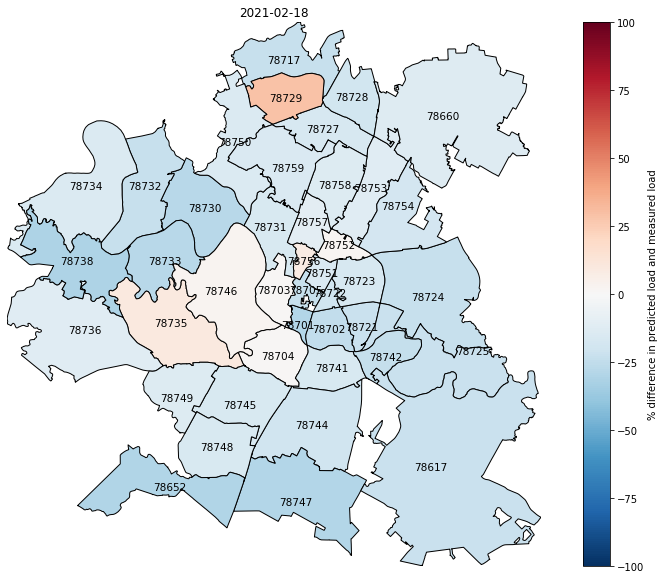

In [31]:
plot_map(f2_outage,i)

In [21]:
f1_outage=final_df_outage1.merge(res_type_id_list[['Service Point','zipCode']],how='inner',on='Service Point').drop('Service Point',axis=1)
f2_outage=f1_outage.groupby(by='zipCode').median().reset_index()
f2_outage

,zipCode,2021-02-11,2021-02-12,2021-02-13,2021-02-14,2021-02-15,2021-02-16,2021-02-17,2021-02-18,2021-02-19
0,78653,-24.659374,-29.215742,-29.473904,-36.110713,1.598382,247.911266,24.963587,-29.199624,-21.190630
1,78660,-10.779836,-19.055921,-22.855997,-28.966914,29.471035,295.753793,144.040963,-14.678753,-17.817602
2,78702,-16.691616,-25.727346,-28.661687,-31.316999,20.301086,251.021943,196.317738,0.506905,-21.318652
3,78703,-21.631484,-24.614994,-26.248564,-30.614468,15.843799,178.809991,62.143672,-0.691128,-29.251711
4,78704,-18.282632,-23.609368,-26.596516,-31.150395,19.271035,151.279700,86.204462,16.329671,-19.428598
5,78717,4.494642,-3.580749,-8.087068,-13.558424,65.331572,639.729353,120.687107,9.354622,17.676226
6,78723,-17.640003,-19.550873,-28.662226,-29.088838,112.496445,2038.474578,-29.346549,-22.813669,-22.257892
7,78725,-9.333337,-17.201784,-18.848059,-25.725046,-22.008683,169.854769,45.481961,-15.968662,-13.176852
8,78729,-19.016414,12.003272,-24.167811,-30.728564,-14.916339,135.671020,153.586892,6.038387,-19.416634
9,78731,3.942692,-4.496621,5.799178,-3.291302,77.642304,173.979060,80.569973,77.315455,81.944985


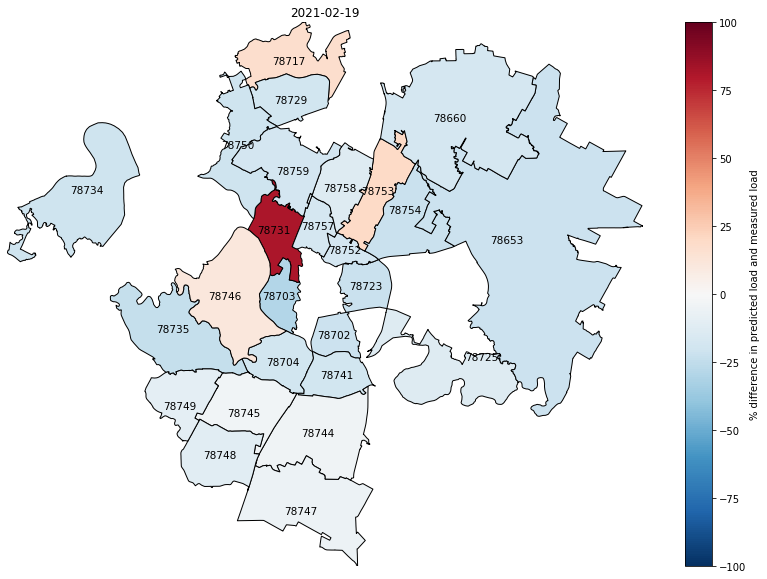

In [40]:
plot_map(f2_outage,'2021-02-19')

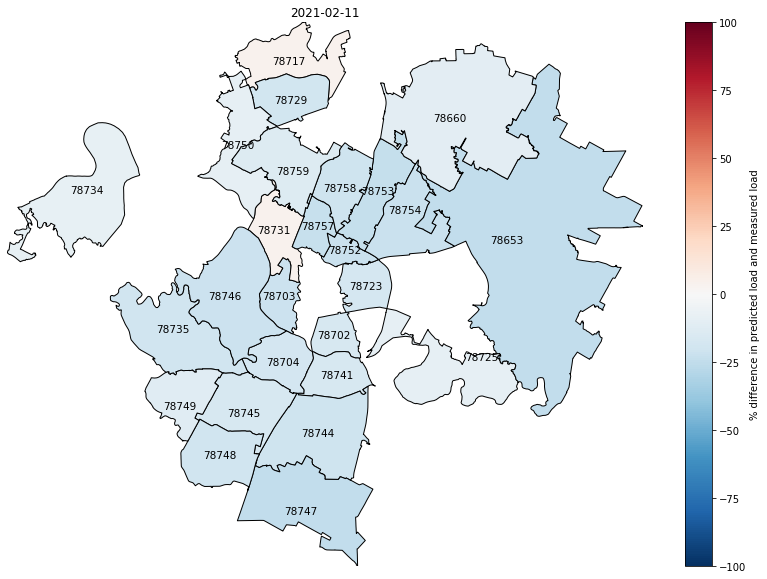

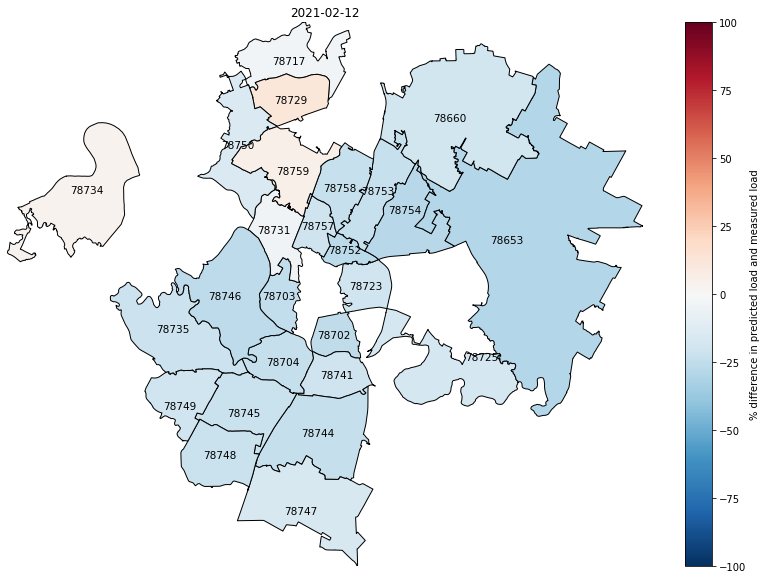

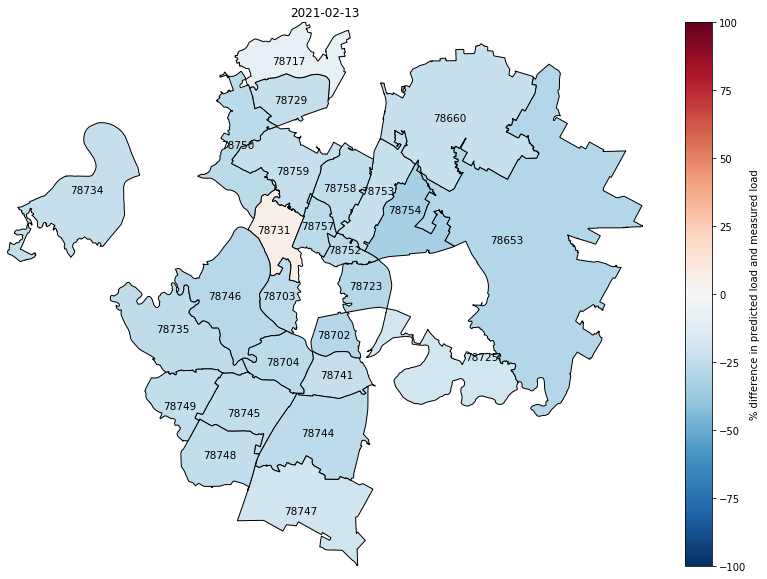

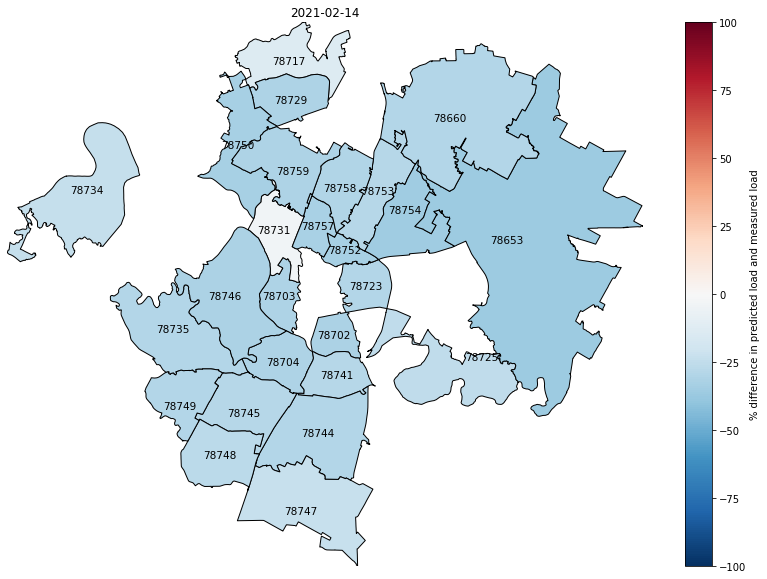

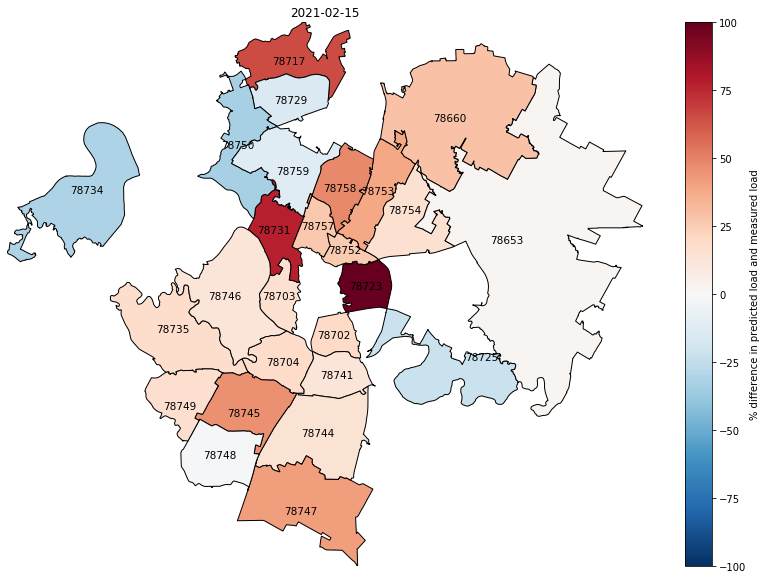

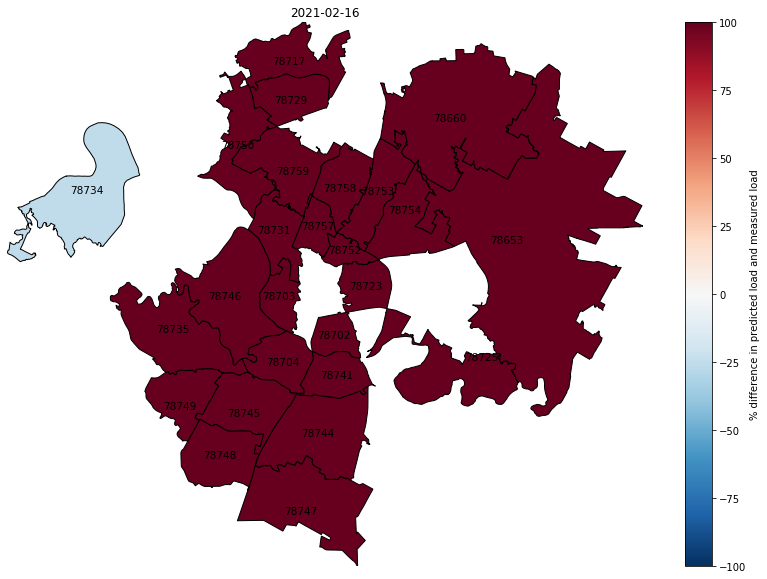

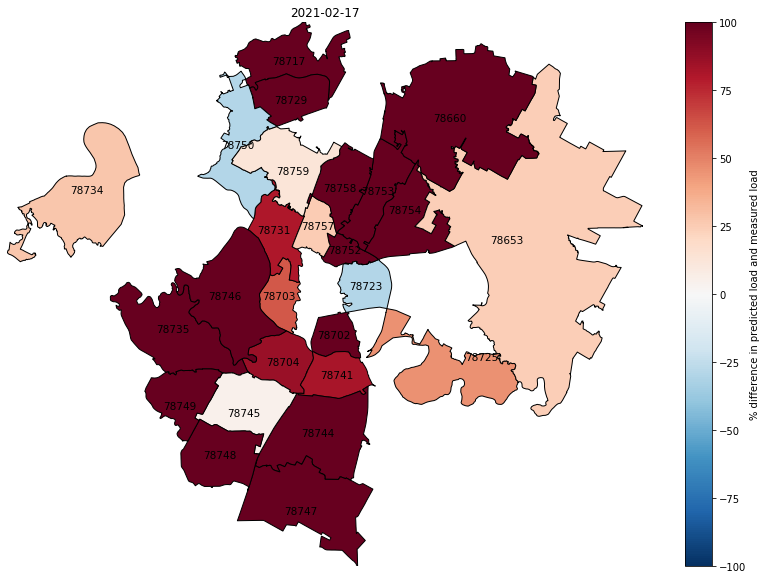

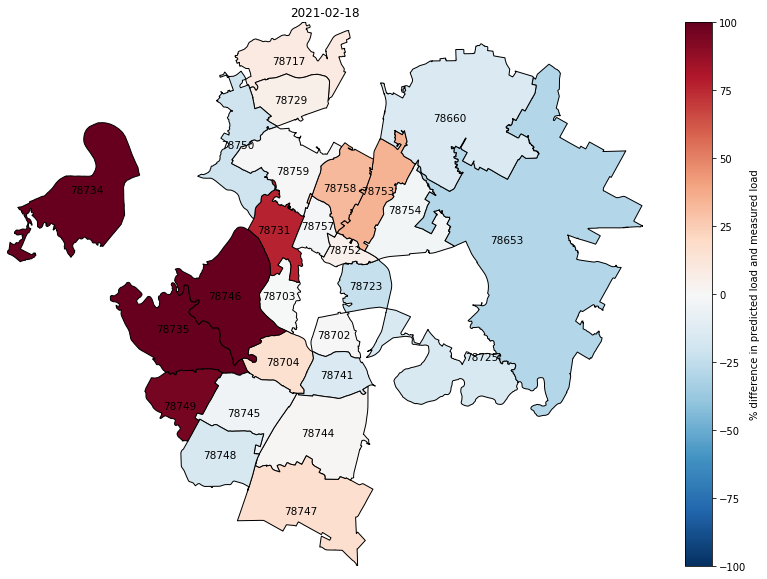

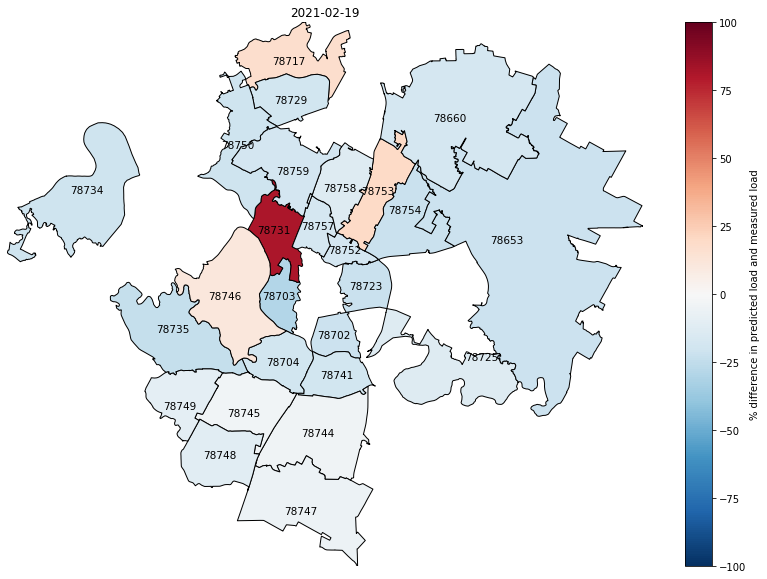

In [35]:

for i in f2_outage[f2_outage.columns[1:]]:
    plot_map(f2_outage,i)